In [40]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import time
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
def make_features(str1, str2, equal, operation):

    # Lots of features that may be important, think about adding more specific cases, same leading or tailing chars? 
    # These are the basic ones tho
    features = {}

    features['str1 len'] = len(str1)
    features['str2 len'] = len(str2)
    features['equal len'] = len(equal)

    features['all len'] = features['str1 len'] + features['str2 len'] + features['equal len']

    overallCount = Counter(str1 + str2 + equal)
    features['unique char'] = len(overallCount)
    features['max occurences'] = max(overallCount.values())
    features['min occurences'] = min(overallCount.values())

    features['reuse ratio'] = len(str1 + str2 + equal) / len(overallCount) if overallCount != 0 else 0
    
    if operation == '+':
        features['operation'] = '1' # 1 = +
    elif operation == '*':
        features['operation'] = '2' # 2 = *
    elif operation == '/':
        features['operation'] = '3' # 3 = /
    else:
        features['operation'] = '4' # 4 = -
    
    str1Count = Counter(str1)
    str2Count = Counter(str2)
    equalCount = Counter(equal)
    sumCount = Counter(str1 + str2)

    features['unique str1 char'] = len(str1Count)
    features['unique str2 char'] = len(str2Count)
    features['unique equal char'] = len(str2Count)
    features['unique 1+2 char'] = len(sumCount)


    features['max str1 occurences'] = max(str1Count.values())
    features['min str1 occurences'] = min(str1Count.values())

    features['max str2 occurences'] = max(str2Count.values())
    features['min str2 occurences'] = min(str2Count.values())
    features['max equal occurences'] = max(equalCount.values())
    features['min equal occurences'] = min(equalCount.values())

    features['max 1+2 occurences'] = max(sumCount.values())
    features['min 1+2 occurences'] = min(sumCount.values())

    features['crypto complexity'] = features['all len'] * features['unique char']

    return features
    


In [24]:
# Asked ChatGPT to generate a list of word patterns to use for learning the best type
word_patterns = [
    # Original patterns
    ("AB", "CD", "EF"),
    ("ABC", "DEF", "GHIJ"),
    ("AB", "CD", "EFG"),
    ("ABCD", "EFGH", "IJKLM"),
    ("ABC", "ABC", "DEFG"),
    ("A", "BC", "DE"),
    ("AB", "C", "DE"),
    
    # Single digit patterns
    ("A", "B", "C"),
    ("A", "B", "CD"),
    ("A", "B", "DE"),
    ("A", "BC", "DE"),
    ("A", "BCD", "EFG"),
    ("A", "BCDE", "FGHI"),
    
    # Two digit patterns
    ("AB", "C", "D"),
    ("AB", "C", "DE"),
    ("AB", "CD", "E"),
    ("AB", "CD", "EF"),
    ("AB", "CD", "EFG"),
    ("AB", "CD", "EFGH"),
    ("AB", "CDE", "FGH"),
    ("AB", "CDE", "FGHI"),
    ("AB", "CDEF", "GHIJ"),
    
    # Three digit patterns
    ("ABC", "D", "E"),
    ("ABC", "D", "EF"),
    ("ABC", "D", "EFG"),
    ("ABC", "DE", "F"),
    ("ABC", "DE", "FG"),
    ("ABC", "DE", "FGH"),
    ("ABC", "DEF", "G"),
    ("ABC", "DEF", "GH"),
    ("ABC", "DEF", "GHI"),
    ("ABC", "DEF", "GHIJ"),
    ("ABC", "DEFG", "HIJK"),
    ("ABC", "DEFG", "HIJKL"),
    
    # Four digit patterns
    ("ABCD", "E", "F"),
    ("ABCD", "E", "FG"),
    ("ABCD", "E", "FGH"),
    ("ABCD", "EF", "G"),
    ("ABCD", "EF", "GH"),
    ("ABCD", "EF", "GHI"),
    ("ABCD", "EFG", "HIJ"),
    ("ABCD", "EFG", "HIJK"),
    ("ABCD", "EFGH", "IJKL"),
    ("ABCD", "EFGH", "IJKLM"),
    ("ABCD", "EFGHI", "JKLMN"),
    
    # Five digit patterns
    ("ABCDE", "F", "G"),
    ("ABCDE", "FG", "H"),
    ("ABCDE", "FGH", "I"),
    ("ABCDE", "FGHI", "J"),
    ("ABCDE", "FGHIJ", "KLMNO"),
    
    # Repeated operand patterns (important for specific puzzle types)
    ("A", "A", "B"),
    ("A", "A", "BC"),
    ("AB", "AB", "C"),
    ("AB", "AB", "CD"),
    ("AB", "AB", "CDE"),
    ("ABC", "ABC", "D"),
    ("ABC", "ABC", "DE"),
    ("ABC", "ABC", "DEF"),
    ("ABC", "ABC", "DEFG"),
    ("ABC", "ABC", "DEFGH"),
    ("ABCD", "ABCD", "E"),
    ("ABCD", "ABCD", "EF"),
    ("ABCD", "ABCD", "EFG"),
    ("ABCD", "ABCD", "EFGH"),
    ("ABCD", "ABCD", "EFGHI"),
    ("ABCDE", "ABCDE", "F"),
    ("ABCDE", "ABCDE", "FG"),
    ("ABCDE", "ABCDE", "FGH"),
    
    # Overlapping character patterns (some shared letters)
    ("AB", "BC", "CD"),
    ("AB", "BC", "CDE"),
    ("ABC", "BCD", "CDE"),
    ("ABC", "BCD", "CDEF"),
    ("ABC", "ADE", "FGH"),
    ("ABC", "ACE", "DEF"),
    ("ABCD", "BCDE", "EFGH"),
    ("ABCD", "ACEF", "BEGH"),
    
    # Asymmetric patterns
    ("A", "BCDE", "FGHI"),
    ("AB", "CDEFG", "HIJKL"),
    ("ABC", "DEFGHI", "JKLMNO"),
    ("ABCDE", "F", "GHIJKL"),
    ("ABCDEF", "G", "HIJKLMN"),
    
    # Medium complexity patterns
    ("AB", "CDE", "FGHI"),
    ("ABC", "DEFG", "HIJKL"),
    ("ABCD", "EFGHI", "JKLMNO"),
    ("AB", "CDEF", "GHIJK"),
    ("ABC", "DEFGH", "IJKLMN"),
    
    # High reuse patterns (for testing character frequency)
    ("AA", "BB", "CC"),
    ("AAB", "BBC", "CCD"),
    ("AABB", "BBCC", "CCDD"),
    ("AAA", "BBB", "CCC"),
    ("AAAA", "BBBB", "CCCC"),
    
    # Mixed reuse patterns
    ("AA", "BC", "DE"),
    ("AB", "CC", "DE"),
    ("AB", "CD", "EE"),
    ("AAB", "CCD", "EEF"),
    ("ABB", "CDD", "EFF"),
    ("ABC", "AAD", "EEF"),
    
    # Edge case patterns (very short or very long)
    ("A", "B", "C"),           # Minimal
    ("ABCDEFG", "H", "I"),     # Very unbalanced
    ("A", "BCDEFGH", "IJKLMNO"), # Extremely unbalanced
    ("ABCDEFGH", "IJKLMNOP", "QRSTUVWXY"), # Very long
    
    # Specific challenging patterns
    ("ABCD", "DCBA", "EFGHI"),  # Reversed patterns
    ("ABC", "CBA", "DEFG"),     # Reversed patterns
    ("AB", "BA", "CDE"),        # Reversed patterns
    
    # Multiplication-friendly patterns (shorter results)
    ("AB", "C", "DE"),
    ("ABC", "D", "EFG"),
    ("AB", "CD", "EFG"),
    ("ABC", "DE", "FGHI"),
    
    # Division-friendly patterns (larger first operand)
    ("ABCD", "AB", "CD"),
    ("ABCDE", "ABC", "DE"),
    ("ABCDEF", "ABC", "DEF"),
    ("ABCDEFG", "ABCD", "EFG"),
    
    # Subtraction patterns (first >= second, result <= first)
    ("ABC", "AB", "C"),
    ("ABCD", "ABC", "D"),
    ("ABCDE", "ABCD", "E"),
    ("ABC", "DE", "FG"),
    ("ABCD", "EF", "GHI"),
    
    # Patterns with maximum character usage (close to 10 unique)
    ("ABCD", "EFGH", "IJ"),     # 10 chars
    ("ABC", "DEFG", "HIJ"),     # 10 chars  
    ("AB", "CDEFG", "HIJ"),     # 10 chars
    ("ABCDE", "FGH", "IJ"),     # 10 chars
    ("AB", "CDEF", "GHIJ"),     # 10 chars
    
    # Real-world inspired patterns (based on actual puzzles)
    ("SEND", "MORE", "MONEY"),  # Classic
    ("TWO", "TWO", "FOUR"),     # Classic
    ("ONE", "ONE", "TWO"),      # Simple
    ("SIX", "SIX", "NINE"),     # Medium
    ("NINE", "FIVE", "EIGHT"),  # Complex
    ("FORTY", "TEN", "SIXTY"),  # Complex
    ("CROSS", "ROADS", "DANGER"), # Very complex
]

In [ ]:
def generate_training_data(num_samples=5000):
    # Need to some how create synthetic training data.
    data = []
    labels = []
    
    valid_puzzles = [
        ("SEND", "MORE", "MONEY", "+"),
        ("TWO", "TWO", "FOUR", "+"),
        ("ABC", "DEF", "GHIJ", "+"),
        ("CAB", "CAB", "DEED", "+"),
        ("EAT", "THAT", "APPLE", "+"),
        ("WE", "WE", "PLAY", "*"),          
        ("US", "US", "YEAH", "*"),          
        ("AB", "C", "DE", "*"),              
        ("A", "BC", "DE", "*"),              
        ("GREAT", "LARGE", "SMALL", "-"),    
        ("WRONG", "RIGHT", "LEFT", "-"),    
        ("MONEY", "SEND", "MORE", "-"),
        ("FORTY", "TEN", "THIRTY", "-")
    ]
    

    for str1, str2, result, op in valid_puzzles:
        features = make_features(str1, str2, result, op)
        data.append(features)
        labels.append(1)
    
    
    operations = ['+', '-', '*', '/']

    # Possibly valid puzzles
    for _ in range(num_samples // 2):
        
        pattern = np.random.choice(len(word_patterns))
        str1_pattern, str2_pattern, result_pattern = word_patterns[pattern]
        operation = np.random.choice(operations)
        
        
        def pattern_to_word(pattern):
            return ''.join(chr(ord('A') + np.random.randint(0, 26)) for _ in pattern)
        
        str1 = pattern_to_word(str1_pattern)
        str2 = pattern_to_word(str2_pattern)
        result = pattern_to_word(result_pattern)
        
        features = make_features(str1, str2, result, operation)
        data.append(features)
        
        
        unique_chars = len(set(str1 + str2 + result))
        if unique_chars <= 10 and len(result) <= max(len(str1), len(str2)) + 2:
            labels.append(1) # Valid
        else:
            labels.append(0)

    # Impossible puzzles
    for _ in range(num_samples // 2):
        
        invalid_type = np.random.randint(0, 4)
        
        if invalid_type == 0:
            str1 = ''.join(chr(ord('A') + i) for i in range(6))
            str2 = ''.join(chr(ord('G') + i) for i in range(6))
            result = ''.join(chr(ord('M') + i) for i in range(6))
            operation = '+'
        elif invalid_type == 1:
            str1 = "ABC"
            str2 = "DEF"
            result = "GHIJKLM"
            operation = '+'
        elif invalid_type == 2:
            str1 = "ABCDE"
            str2 = "FGHIJ"
            result = "KL"
            operation = '+'
        else:
           
            str1 = ''.join(chr(ord('A') + np.random.randint(0, 26)) for _ in range(np.random.randint(1, 8)))
            str2 = ''.join(chr(ord('A') + np.random.randint(0, 26)) for _ in range(np.random.randint(1, 8)))
            result = ''.join(chr(ord('A') + np.random.randint(0, 26)) for _ in range(np.random.randint(1, 12)))
            operation = np.random.choice(['+', '-', '*', '/'])
        
        features = make_features(str1, str2, result, operation)
        data.append(features)
        labels.append(0)  # Invalid
    

    
    return data, labels
    
    

In [49]:
def train_classifier():
    data, labels = generate_training_data()

    df = pd.DataFrame(data)
    X = df.fillna(0)
    y = np.array(labels)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

    clf.fit(X_train, y_train)

    train_score = clf.score(X_train, y_train)

    test_score = clf.score(X_test, y_test)

    print(f"Training accuracy: {train_score:.3f}")
    print(f"Test accuracy: {test_score:.3f}")
    
    
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': clf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 most important features:")
    print(feature_importance.head(10))
    
    y_pred = clf.predict(X_test)
    print(f"\nClassification Report:")
    cm = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None, normalize=None)
    print(confusion_matrix(y_test, y_pred, labels=None, sample_weight=None, normalize=None))
    labels = ["No Solution", "Solution"]
    plt.figure(figsize=(6,6))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    print(classification_report(y_test, y_pred))
    
    return clf, X.columns



Training accuracy: 0.963
Test accuracy: 0.963

Top 10 most important features:
              feature  importance
4         unique char    0.263293
21  crypto complexity    0.258135
3             all len    0.124504
2           equal len    0.115307
1            str2 len    0.051649
12    unique 1+2 char    0.049440
11  unique equal char    0.044290
9    unique str1 char    0.021886
10   unique str2 char    0.021013
7         reuse ratio    0.019298

Classification Report:
[[525  33]
 [  4 441]]


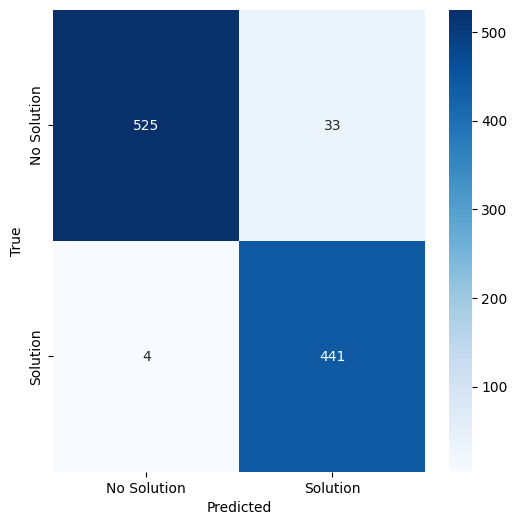

              precision    recall  f1-score   support

           0       0.99      0.94      0.97       558
           1       0.93      0.99      0.96       445

    accuracy                           0.96      1003
   macro avg       0.96      0.97      0.96      1003
weighted avg       0.96      0.96      0.96      1003



In [50]:
clf, columns = train_classifier()